In [77]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import collections
import re
import random

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [78]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [79]:
num_hiddens = 512
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell,
    return_sequences=True, return_state=True)

state = rnn_cell.get_initial_state(batch_size=batch_size)
print(tf.squeeze(tf.convert_to_tensor(state)).shape)

(32, 512)


In [80]:
##keras 3.0后，能够自动识别格式，不需要通过time_major告诉模型，数据已经按照num_steps、batch_size的格式处理好了
X = tf.random.uniform((batch_size, num_steps, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([32, 35, 512]), 32, TensorShape([512]))

In [81]:
#@save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        
        ##原书代码中对input tf.transpose了下，keras v3不需要了
        X = tf.one_hot(inputs, self.vocab_size)
        # rnn返回两个以上的值
        
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

In [82]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller ', 10, net, vocab)

'time traveller icdmrixaje'

困惑度 1.4, 1127.0 词元/秒 /GPU:0
time traveller t mengshtha ingsheabt ctire ter ablerypreert ithem
traveller authe the painer u fiea ea noglint an manthe way o


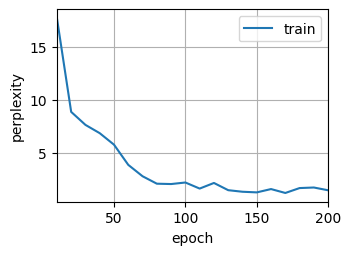

In [83]:
num_epochs, lr = 200, 1.0
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy, kerasV3=True)